In [1]:
import uproot
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick

In [2]:
mass = 3000
i = 0
ar_raw = uproot.concatenate([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M{mass}/cat_base/prod_241023c/data_{i}.root:Events"],
        filter_name=["boostedTau*", "Muon_*", "Electron_*", "GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_eta", "GenPart_phi", "GenPart_pt", "nGenVisTau", "GenVisTau*",
        "cutflow*", "pairType*", "is*", "GenPair*", "genDau*", "dau*"],
        how="zip")

In [3]:

def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)
def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)


In [4]:
def filterDeltaRLepton(ar, dR_cutoff):
    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    deltaR = delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi)
    return ar[ak.fill_none(deltaR < dR_cutoff, False)]

def filterDeltaRDiTau(ar, dR_cutoff=0.6): # not sure about the deltaR cut (probably 0.3 iso cone for a tau ?)
    genDau1 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    deltaR = delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi)
    return ar[ak.fill_none(deltaR < dR_cutoff, False)]

def filterDeltaR(ar, pairType):
    if pairType == 0: return filterDeltaRLepton(ar, 0.7)
    elif pairType == 1: return filterDeltaRLepton(ar, 0.6)
    elif pairType == 2: return filterDeltaRDiTau(ar)
    else: raise ValueError()
# def genDaus(ar):
#     genpart = ak.firsts(ar.GenPart[ak.drop_none(ak.singletons(ar.genDau1_genPartIdx))])
#     ar = ak.with_field(
#         ar,
#         ak.where((ar.GenPairType >= 0) & (ar.GenPairType <= 1), 
#                      genpart[["pt", "eta", "phi"]],
#                      ak.where(ar.GenPairType == 2,
#                               ak.firsts(ar.GenVisTau)[["pt", "eta", "phi"]],
#                               None)
#                      ),
#         "genDau1"
#     )
#     return ar
def filterDetectorAcceptance(ar, pairType):
    if pairType < 2:
        genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    else:
        genDau1 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    if pairType == 0:
        dau1_sel = (genDau1.pt > 15 ) & (genDau1.eta < 2.4)
    elif pairType == 1:
        dau1_sel = (genDau1.pt > 20 ) & (genDau1.eta < 2.5)
    else:
        dau1_sel = (genDau1.pt > 20 ) & (genDau1.eta < 2.1)
    dau2_sel = (genDau2.pt > 20 ) & (genDau2.eta < 2.1)
    return ar[dau1_sel & dau2_sel]

def readVID(vid):
    cuts_expl = ["MinPtCut","GsfEleSCEtaMultiRangeCut","GsfEleEBEECut","GsfEleEBEECut","GsfEleEBEECut","GsfEleHadronicOverEMEnergyScaledCut","GsfEleEBEECut","GsfEleRelPFIsoScaledCut","GsfEleConversionVetoCut","GsfEleMissingHitsCut"]
    for bitn in range(9+1):#[0,1,2,3,4,5,6,8,9]:
        cut_value = (vid >> (bitn*3)) & ((1 << 3) - 1)
        if cut_value != 4:
            print(f"{cuts_expl[bitn]} (bit {bitn}) = {cut_value}")

In [5]:
ar_mutau =filterDeltaRLepton(filterDetectorAcceptance(ar_raw[ar_raw.GenPairType == 0], 0), 0.7)
ar_etau = filterDeltaRLepton(filterDetectorAcceptance(ar_raw[ar_raw.GenPairType == 1], 1), 0.6) 
ar_tautau = filterDeltaRDiTau(filterDetectorAcceptance(ar_raw[ar_raw.GenPairType == 2], 2))

In [6]:
genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
genDau1

NameError: name 'ar' is not defined

In [16]:
ar = ar_etau[(ar_etau.pairType_boostedTaus != 1) & (~ar_etau.cutflow_boostedTaus_dau1_LeptonID) & (~ar_etau.cutflow_boostedTaus_dau1_LeptonIso)&(~ar_etau.cutflow_boostedTaus_dau1_Reco)]
len(ar)

1103

In [36]:
[not evt[f] for f in evt.fields if f.startswith("cutflow_boostedTaus")]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [40]:
for i, evt in enumerate(ar):
    count_fail = 0
    for f in evt.fields:
        
        if f.startswith("cutflow_boostedTaus"):
            # if evt[f]:
            #     print(f)
            if evt[f]: count_fail += 1
    if count_fail == 0: print(i)


932


In [54]:
ar = ar_etau[(ar_etau.pairType_boostedTaus != 1) & (~ar_etau.cutflow_boostedTaus_dau1_LeptonID)]

In [41]:
ev = ar[932]
for f in ev.fields: 
    if f.startswith("cutflow_boostedTaus") and ev[f]: print(f"{f} = {ev[f]}")

In [18]:
ev.GenPart[ev.genDau1_genPartIdx]

<Record {genPartIdxMother: 14, pdgId: 11, ...} type='{genPartIdxMother: int...'>

In [42]:
ev.Electron[0]

<Record {cutBased: 0, ...} type='{cutBased: uint8, vidNestedWPBitmap: int32...'>

In [57]:
ev.boostedTau[0][["pt", "eta", "phi"]]

<Record {pt: 426, eta: -0.621, phi: 2.2} type='{pt: float32, eta: float32, ...'>

In [58]:
delta_r(-0.621, 2.2, -0.633, 2.16)

0.04176122603564224

In [43]:
ev.pairType_boostedTaus

-1

In [32]:
readVID(ev.Electron[0].vidNestedWPBitmap)

GsfEleEBEECut (bit 2) = 3
GsfEleRelPFIsoScaledCut (bit 7) = 0


In [45]:
ev.pairType_HPSTaus

-1

In [29]:

ar = ar[cut_dau1[mass] & cut_dau2[mass]]
ar_wrong = ar[ar.cutflow_boostedTaus_dau1_WrongPair]
eff(ar.cutflow_boostedTaus_dau1_WrongPair, ar)

0.04716981132075472

In [15]:
ev = ar_wrong[0]
ev.genDau1_genPartIdx, ev.dau1_index, ev.dau1_pt, ev.dau1_eta, ev.dau1_phi, ev.cutflow_boostedTaus_dau1_WrongPair, ev.pairType

(48, -1, -999.0, -1.0, -1.0, True, -1)

In [16]:
ev[[f for f in ev.fields if f.startswith("cutflow_boostedTaus_dau1")]]

<Record {...} type='{cutflow_boostedTaus_dau1_DeltaR: bool, cutflow_boosted...'>

In [17]:
ev.GenPart[ev.genDau1_genPartIdx]

<Record {genPartIdxMother: 15, pdgId: -11, ...} type='{genPartIdxMother: in...'>

In [18]:
ev.Electron[ev.dau1_index]

<Record {eta: -0.352, mass: 0.017, ...} type='{eta: float32, mass: float32,...'>

In [20]:
ar = ars_raw[3000][ars_raw[3000].GenPairType == 0]
genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))

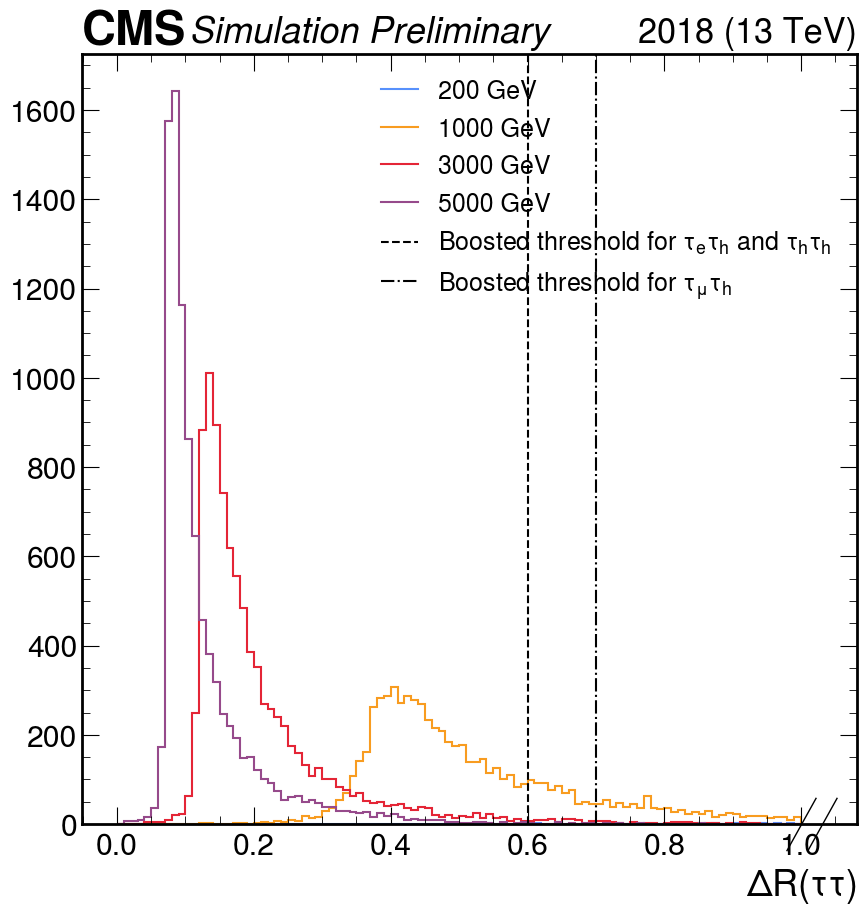

In [22]:
hs = dict()
for mass, ar_nofilter in ars_raw.items():
    cut = (ar_nofilter.GenPairType == 1) 

    cut = ~ar_nofilter.cutflow_boostedTaus_dau1_Reco
    cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Pt
    cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Eta & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonID & ~ar_nofilter.cutflow_boostedTaus_dau1_Vertex
    cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonIso

    ar = ar_nofilter[cut]

    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))
    h = hist.Hist(hist.axis.Regular(100, 0., 1., label=r"$\Delta R (\tau\tau)$"))
    h.fill(deltaR)
    hs[mass] = h
hep.histplot(list(hs.values()), label=[str(m) + " GeV" for m in hs.keys()], yerr=False)
plt.axvline(0.6, ls="--", color="black", label=r"Boosted threshold for $\tau_e \tau_h$ and $\tau_h \tau_h$")
plt.axvline(0.7, ls="-.", color="black", label=r"Boosted threshold for $\tau_\mu \tau_h$")
hep.cms.label("Preliminary", year=2018)
plt.legend()
#plt.xscale("log")

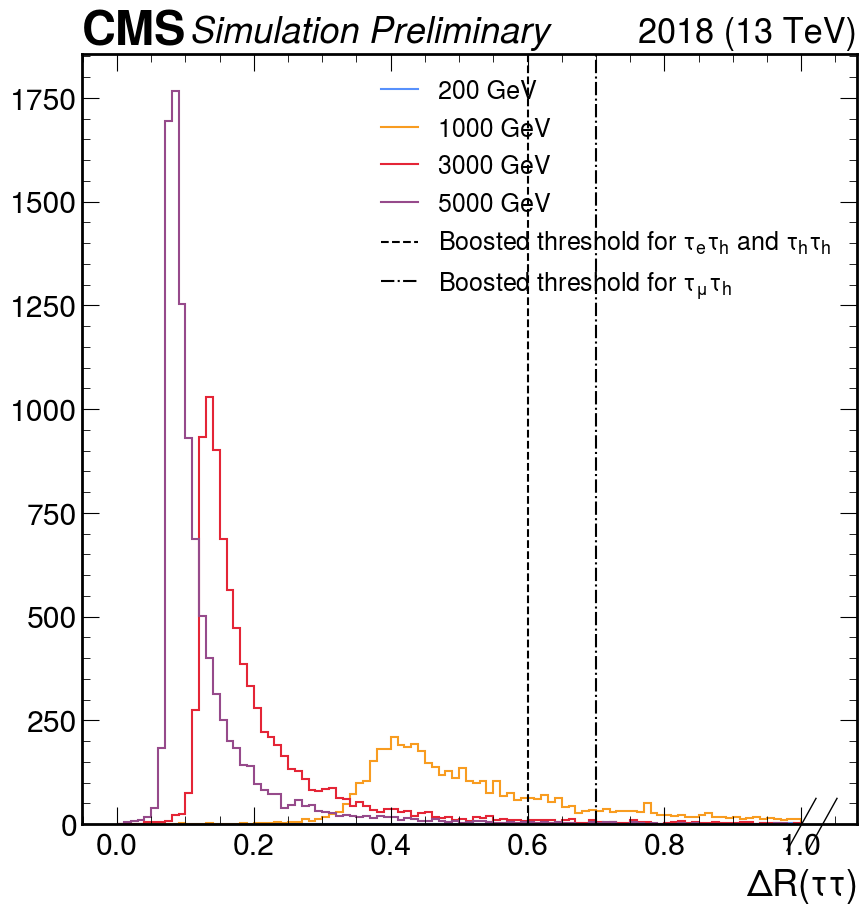

In [23]:
hs = dict()
for mass, ar_nofilter in ars_raw.items():
    cut = (ar_nofilter.GenPairType == 0) 

    # cut = ~ar_nofilter.cutflow_boostedTaus_dau1_Reco
    # cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Pt
    # cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Eta & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonID & ~ar_nofilter.cutflow_boostedTaus_dau1_Vertex
    # cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonIso

    ar = ar_nofilter[cut]

    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))
    h = hist.Hist(hist.axis.Regular(100, 0., 1., label=r"$\Delta R (\tau\tau)$"))
    h.fill(deltaR)
    hs[mass] = h
hep.histplot(list(hs.values()), label=[str(m) + " GeV" for m in hs.keys()], yerr=False)
plt.axvline(0.6, ls="--", color="black", label=r"Boosted threshold for $\tau_e \tau_h$ and $\tau_h \tau_h$")
plt.axvline(0.7, ls="-.", color="black", label=r"Boosted threshold for $\tau_\mu \tau_h$")
hep.cms.label("Preliminary", year=2018)
plt.legend()
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

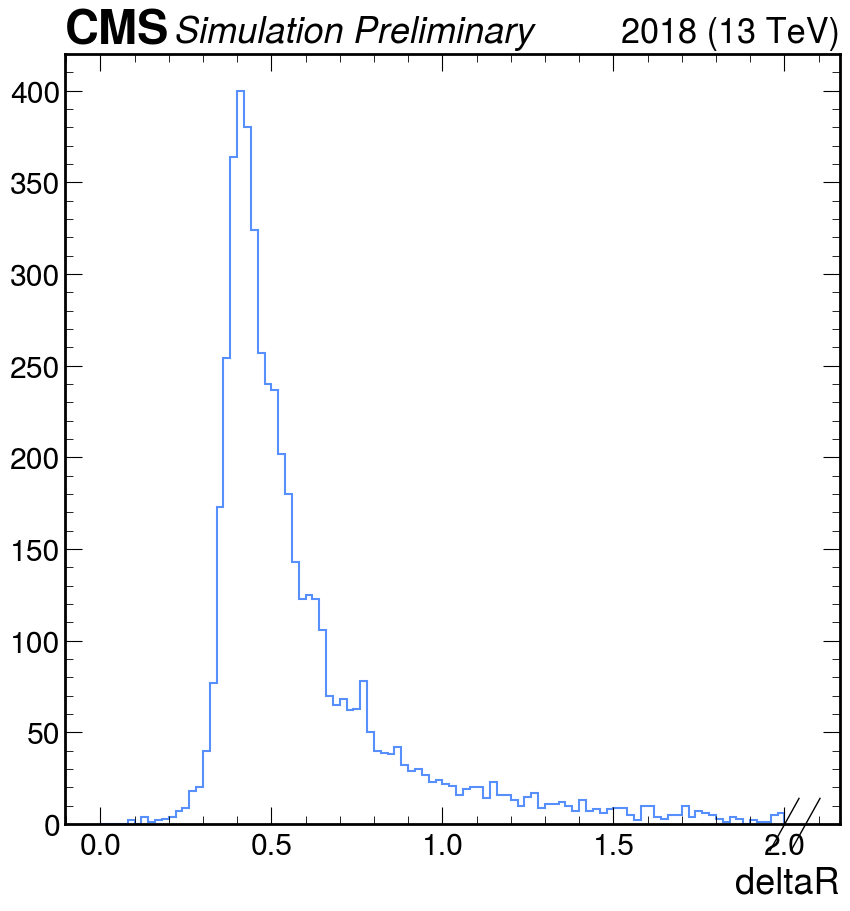

In [24]:
ar = ars_raw[1000]
ar = ar[ar.GenPairType == 0]
genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))
h = hist.Hist(hist.axis.Regular(100, 0., 2., label="deltaR"))
h.fill(deltaR)
hep.histplot(h, yerr=False)
hep.cms.label("Preliminary", year=2018)